In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run nnn/ipynb_init.py

## Getting started

In [2]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file, sodium=0.075)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                      annotation_file=annotation_file,
                    )
saltdata = ArrayData(replicate_df=replicate_df.iloc[4,:],
                    annotation_file=annotation_file)

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
39.48% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


In [3]:
arr = arraydata.data.join(arraydata.annotation)
arr['scaffold'] =arr.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

salt = saltdata.data.join(saltdata.annotation)
salt['scaffold'] = salt.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

annotation['scaffold'] = annotation.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

## Tests

No need to run. For testing functions in the motif_fit module.

### Some math:

In [5]:
df = arr.query('Series == "WatsonCrick"')

In [6]:
feats = mf.get_feature_count_matrix(df, feature_method='get_stack_feature_list_simple_loop', fit_intercept=True)

y = df['dG_37']
y_err = df['dG_37_se']
A = feats / y_err.values.reshape(-1,1)
b = (y/y_err).values

In [11]:
np.linalg.matrix_rank(A)

16

0.12807029307039808

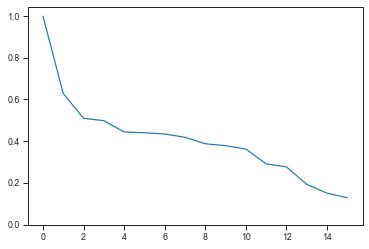

In [12]:
u,s,v = np.linalg.svd(A, full_matrices=False)

plt.plot(s / s[0])
plt.ylim(bottom=0)
s[-1] / s[0]

In [13]:
s_inv = 1/s
s_inv[s < s[0]*0.0] = 0

In [14]:
nn_se = np.sqrt(np.sum((v.T * s_inv.reshape(1,-1))**2, axis=1))
nn_se

array([0.00296321, 0.00609913, 0.00461605, 0.00527528, 0.00595214,
       0.00496498, 0.00607997, 0.00591374, 0.00423795, 0.00661187,
       0.00305791, 0.00460081, 0.00552796, 0.00588799, 0.00491829,
       0.00297761])

In [15]:
N, M = A.shape
ubsv = (((u.T @ b.reshape(-1,1)) * s_inv.reshape(-1,1)).T * v)
nn = np.sum(ubsv, axis=1)

In [16]:
nn

array([ 0.37881806,  1.07444686,  0.72153573,  0.35746069,  0.44608097,
        0.03272619, -0.46921708, -0.31195844,  0.10834488, -0.20647181,
       -0.33767852,  0.3391572 , -0.09379868, -0.04255375,  0.05708336,
       -0.25081465])

In [17]:
(v.T @ np.diag(s_inv) @ u.T @ b.reshape(-1,1))

array([[ 0.09676635],
       [-0.77776858],
       [-0.26179628],
       [-0.23253494],
       [ 0.34430845],
       [-0.34408988],
       [-0.0897945 ],
       [ 0.16639796],
       [-0.05137271],
       [-1.05884861],
       [-0.39029165],
       [-0.40545277],
       [ 0.39160479],
       [-0.44258214],
       [-0.14729484],
       [ 0.05503769]])

In [18]:
np.linalg.pinv(A) @ b.reshape(-1,1)

array([[ 0.09676635],
       [-0.77776858],
       [-0.26179628],
       [-0.23253494],
       [ 0.34430845],
       [-0.34408988],
       [-0.0897945 ],
       [ 0.16639796],
       [-0.05137271],
       [-1.05884861],
       [-0.39029165],
       [-0.40545277],
       [ 0.39160479],
       [-0.44258214],
       [-0.14729484],
       [ 0.05503769]])

In [41]:
ubs = (u[:,:M] * b.reshape(-1,1)) * s_inv.reshape(1,-1)
ubs.shape

(2744, 16)

In [67]:
((u[:,:M].T @ b.reshape(-1,1)) * s_inv).T.shape

(16, 16)

In [64]:
(((u[:,:M].T @ b.reshape(-1,1)) * s_inv.reshape(-1,1)).T * v).shape

(16, 16)

In [42]:
v.reshape(-1,1).shape

(256, 1)

In [24]:
feats

,AA_TT,AC_GT,AG_CT,AT_AT,CA_TG,CC_GG,CG_CG,CT_AG,GA_TC,GC_GC,GG_CC,GT_AC,TA_TA,TC_GA,TG_CA,TT_AA
SEQID,,,,,,,,,,,,,,,,
WC0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WC1,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
WC10,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
WC100,1,0,1,1,0,0,0,0,2,0,0,0,0,0,0,0
WC1000,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WC994,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1
WC995,0,0,1,0,0,0,1,0,0,1,0,1,1,0,0,1
WC997,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1


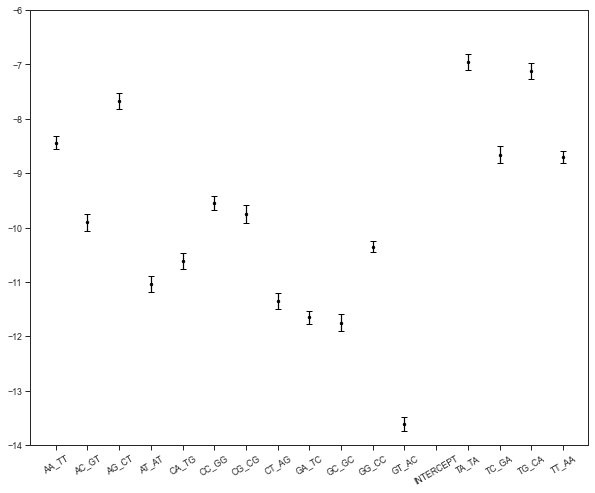

In [49]:
_, ax = plt.subplots(figsize=(10,8))
ax.errorbar(np.arange(len(coef)), coef, coef_se, fmt='k.', capsize=3)

ax.set_xticks(np.arange(len(coef)))
ax.set_xticklabels(feats.columns, rotation=30)
plt.ylim([-14,-6])
plt.show()

### validating functions

Rank of the design matrix A is 17 / 17
Condition number of the design matrix A is 16.58


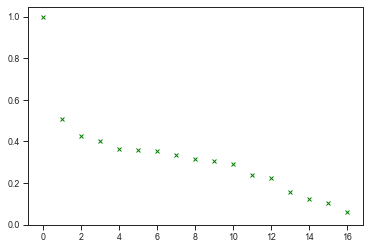

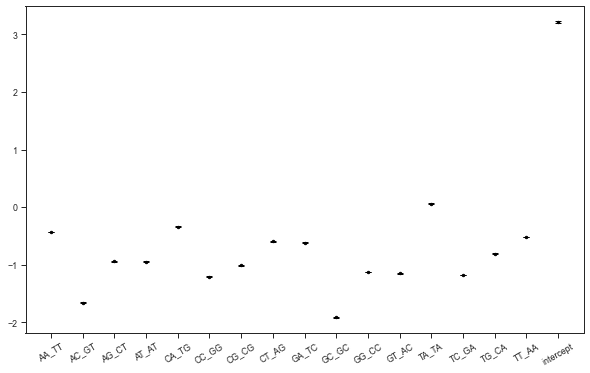

In [8]:
y = df['dG_37'].values
y_err = df['dG_37_se'].values
coef, coef_se = mf.solve_linear_regression(feats, y, y_err, verbose=True)

In [9]:
lr = mf.LinearRegressionSVD()
lr.fit(feats, y, y_err)

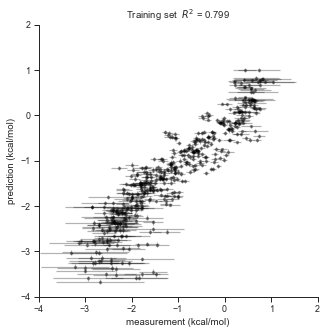

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
plt.errorbar(y[-500:], lr.predict(feats.values[-500:,:]), 
             xerr=y_err[-500:], yerr=1*lr.predict_err(feats.values[-500:,:]), fmt='.', color='k', alpha=.3)
plt.xlim([-4,2])
plt.ylim([-4,2])
ax.set_xlabel('measurement (kcal/mol)')
ax.set_ylabel('prediction (kcal/mol)')
ax.set_title('Training set  $R^2$ = %.3f'%r2_score(y, lr.predict(feats)))
sns.despine()

In [165]:
pearson,_ = pearsonr(y_err, lr.predict_err(feats.values))


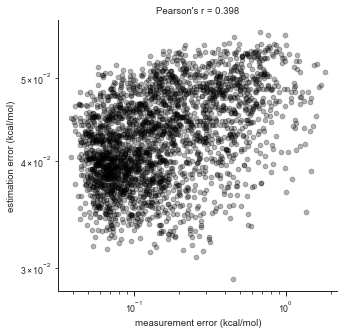

In [163]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(y_err,lr.predict_err(feats.values), c='k', alpha=.3)
# plt.xlim([0,1.2])
# plt.ylim([0,0.1])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('measurement error (kcal/mol)')
plt.ylabel('estimation error (kcal/mol)')
plt.title("Pearson's r = %.3f"%pearson)
sns.despine()

## WC models

### Get the two-state filter

In [17]:
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
myfilter = "dH_err_rel < 0.2 & Tm_err_abs < 2 & redchi < 1.5"
line_fit = []

for i in range(3):
    rep = arraydata.get_replicate_data(replicate_df.iloc[i]['name'])
    result_df = pd.read_table('./data/fitted_variant/dG_fit_%s_v0.0.2.tsv' % replicate_df.iloc[i]['replicate']).set_index('SEQID')
    df = rep.join(result_df, lsuffix='_curve', rsuffix='_line')
    df['Tm_err_abs'] = np.abs(df.Tm_curve - df.Tm_line)
    df['dH_err_rel'] = - np.abs(df.dH_curve - df.dH_line) / df.dH_line
    df['two_state'] = df.eval(myfilter)
    # df['BIC_ratio'] = df.BIC3 / df.BIC1
    line_fit.append(df)

Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211221_v9.CPvariant.gz
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


70.51% variants pass the two state filter


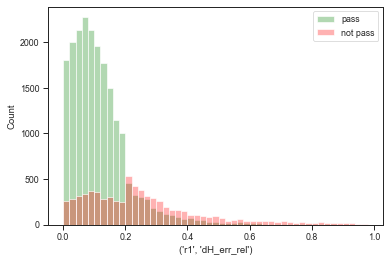

In [133]:
cols = ['dH_err_rel', 'Tm_err_abs', 'redchi', 'two_state']
twostate_df = pd.concat([d[cols] for d in line_fit], axis=1, keys=['r1', 'r2', 'r3'])
n_pass = np.nansum(twostate_df.xs('two_state', axis=1, level=1), axis=1)
pass_df = pd.DataFrame(data=n_pass >= 2, index=twostate_df.index, columns=['two_state'])

sns.histplot(twostate_df[n_pass >= 2]['r1','dH_err_rel'].dropna(), 
             bins=np.arange(0,1,0.02), alpha=.3,# stat='density',
             color='g')
sns.histplot(twostate_df[n_pass < 2]['r1','dH_err_rel'].dropna(), 
             bins=np.arange(0,1,0.02), alpha=.3,# stat='density',
             color='r')
plt.legend(['pass', 'not pass'])

print('%.2f%% variants pass the two state filter' % (np.sum(n_pass >= 2) / len(n_pass) * 100))

### Train test split

First test without the symmetry hypothesis. AC_GT is independent of GT_AC. For SantaLucia, I make a copy of the parameter values.

In [186]:
df = arr.join(pass_df, how='left').query('Series == "WatsonCrick" & two_state == True')
df = df.query("dG_37_se < .3")
feats = mf.get_feature_count_matrix(df, feature_method='get_stack_feature_list_simple_loop', fit_intercept=True, symmetry=False)
y = df['dG_37']
y_err = df['dG_37_se']
X_train, X_test, y_train, y_test, yerr_train, yerr_test = sklearn.model_selection.train_test_split(feats.values, y.values, y_err.values, 
                                                                                                   test_size=0.25, random_state=42, 
                                                                                                   stratify=df.ConstructType)

In [208]:
lr_asym = util.LinearRegressionSVD()
lr_asym.fit(X_train, y_train, yerr_train, feature_names=feats.columns.tolist())

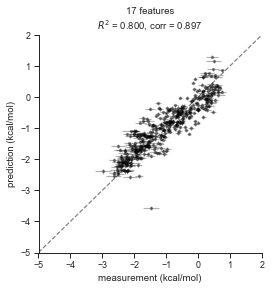

In [198]:
mf.plot_truth_predict(lr_asym, X_test, y_test, yerr_test, lim=[-5,2])
util.save_fig('./fig/motif_fit/WC_MANifold_test_set.pdf')

In [209]:
lr_asym.metrics

{'rsqr': 0.8012380373813666,
 'rmse': 0.4122654471578566,
 'dof': 1147,
 'chisq': 222062192.36431834,
 'redchi': 193602.60886165506}

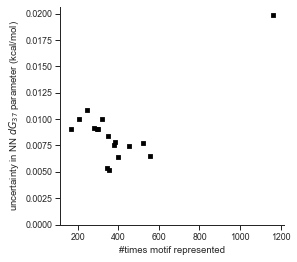

In [191]:
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(np.sum(X_train, axis=0), lr_asym.coef_se_, color='k', marker='s')
plt.ylim(bottom=0)
# plt.xlim([400,1000])
plt.xlabel('#times motif represented')
plt.ylabel('uncertainty in NN $dG_{37}$ parameter (kcal/mol)')
sns.despine()

Get a "full" SantaLucia parameter set with the symmetrical motifs.

In [3]:
santalucia

,motif_paper,dH,dS,dG_37
0,AA_TT,-7.6,-21.3,-1.00
1,AT_AT,-7.2,-20.4,-0.88
2,TA_TA,-7.2,-21.3,-0.58
3,CA_TG,-8.5,-22.7,-1.45
4,GT_AC,-8.4,-22.4,-1.44
5,CT_AG,-7.8,-21.0,-1.28
6,GA_TC,-8.2,-22.2,-1.30
7,CG_CG,-10.6,-27.2,-2.17
8,GC_GC,-9.8,-24.4,-2.24
9,GG_CC,-8.0,-19.9,-1.84


In [2]:
santalucia = pd.read_table('./data/literature/SantaLucia.tsv')
santalucia.motif_paper = santalucia.motif_paper.apply(util.convert_santalucia_motif_representation)
santalucia_full = santalucia.copy()


for i,row in santalucia.iterrows():
    sym_motif = '_'.join(row.motif_paper.split('_')[::-1])
    print(row.motif_paper, sym_motif, sym_motif in santalucia.motif_paper.tolist())
    if not sym_motif in santalucia.motif_paper.tolist():
        new_row = row.copy()
        new_row.motif_paper = sym_motif
        # print(new_row)
        santalucia_full = pd.concat([santalucia_full, pd.DataFrame(new_row).T], axis=0)

AA_TT TT_AA False
AT_AT AT_AT True
TA_TA TA_TA True
CA_TG TG_CA False
GT_AC AC_GT False
CT_AG AG_CT False
GA_TC TC_GA False
CG_CG CG_CG True
GC_GC GC_GC True
GG_CC CC_GG False


In [140]:
santalucia_full = santalucia_full.set_index('motif_paper').loc[feats.columns[:-1],:]
assert santalucia_full.shape[0] == feats.shape[1] - 1

santalucia_full.to_csv('./data/literature/SantaLucia_full.tsv', sep='\t')

In [141]:
sl = util.LinearRegressionSVD()
sl.coef_ = np.append(santalucia_full['dG_37'].values, 0)
sl.coef_se_ = np.zeros_like(sl.coef_)

<AxesSubplot:title={'center':'17 features\n$R^2$ = -35.959, corr = 0.810'}, xlabel='measurement (kcal/mol)', ylabel='prediction (kcal/mol)'>

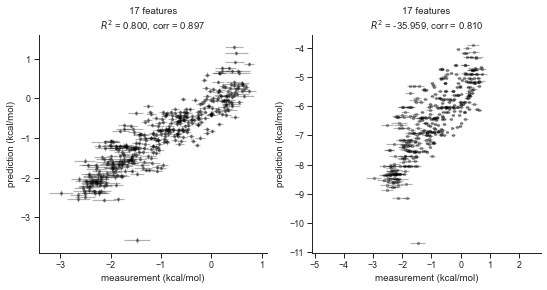

In [142]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
mf.plot_truth_predict(lr_asym, X_test, y_test, yerr_test, ax=ax[0])
mf.plot_truth_predict(sl, X_test, y_test, yerr_test, ax=ax[1])

In [143]:
sl.fit_intercept_only(X_train, y_train)

<AxesSubplot:title={'center':'17 features\n$R^2$ = 0.434, corr = 0.810'}, xlabel='measurement (kcal/mol)', ylabel='prediction (kcal/mol)'>

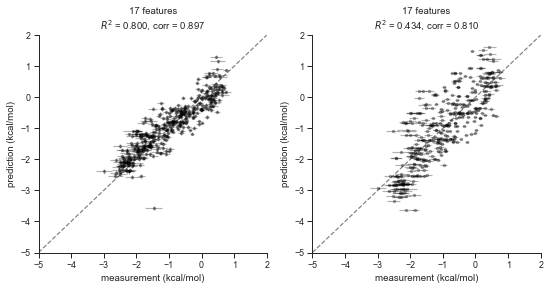

In [144]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
mf.plot_truth_predict(lr_asym, X_test, y_test, yerr_test, ax=ax[0], lim=[-5,2])
mf.plot_truth_predict(sl, X_test, y_test, yerr_test, ax=ax[1], lim=[-5,2])

### With symmetry assumption

In [169]:
santalucia_new = pd.read_table('./data/literature/SantaLucia_flipped.csv')

In [170]:
df = arr.join(pass_df, how='left').query('Series == "WatsonCrick" & two_state == True')
df = df.query("dG_37_se < .3")
feats = mf.get_feature_count_matrix(df, feature_method='get_stack_feature_list_simple_loop', 
                                    fit_intercept=True, symmetry=True)
y = df['dG_37']
y_err = df['dG_37_se']
X_train, X_test, y_train, y_test, yerr_train, yerr_test = sklearn.model_selection.train_test_split(feats.values, y.values, y_err.values, 
                                                                                                   test_size=0.25, random_state=42, 
                                                                                                   stratify=df.ConstructType)

lr_sym = util.LinearRegressionSVD()
lr_sym.fit(X_train, y_train, yerr_train, feature_names=feats.columns.tolist())

In [171]:
sl_sym = util.LinearRegressionSVD(param='dG_37')
sl_sym.set_coef(feature_names=feats.columns, coef_df=santalucia_new, index_col='motif')
sl_sym.fit_intercept_only(X_train, y_train)

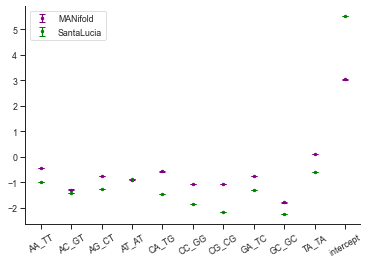

In [177]:
fig, ax = plt.subplots()
plotting.plot_fitted_coef(lr_sym, ax=ax, c='purple')
plotting.plot_fitted_coef(sl_sym, ax=ax, c='g')
plt.legend(['MANifold', 'SantaLucia'])
util.save_fig('./fig/motif_fit/WC_MANifold_vs_SantaLucia_dG_37_parameters.pdf')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 11 is different from 64)

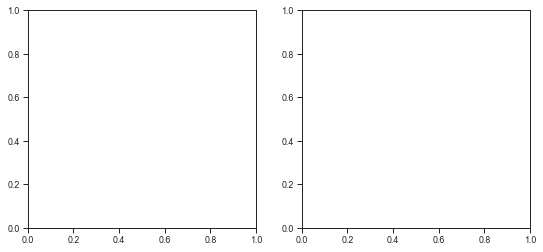

In [185]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
mf.plot_truth_predict(lr_sym, X_test, y_test, yerr_test, ax=ax[0], lim=[-5,2])
mf.plot_truth_predict(sl_sym, X_test, y_test, yerr_test, ax=ax[1], lim=[-5,2])
util.save_fig('./fig/motif_fit/MANifold_vs_SantaLucia_test_set_symmetric_motifs.pdf')

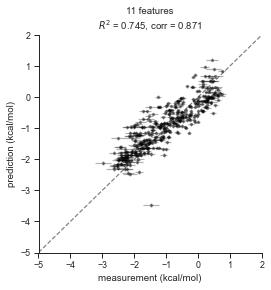

In [174]:
mf.plot_truth_predict(lr_sym, X_test, y_test, yerr_test, lim=[-5,2])
util.save_fig('./fig/motif_fit/WC_MANifold_test_set_sym.pdf')

**Test the model on non-two-state variants**

Note that this is not ideal as we are still using 2 state assumption. We need to plug the parameters back into NUPACK to truly evaluate non-2state behavior.

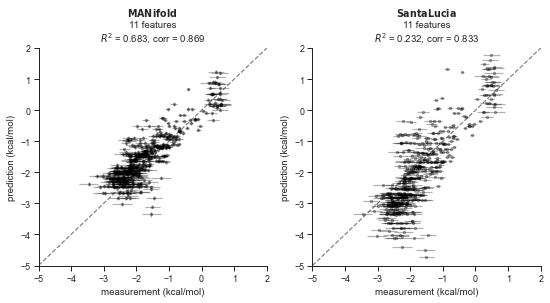

In [181]:
df = arr.join(pass_df, how='left').query('Series == "WatsonCrick" & two_state == False')
df = df.query('dG_37_se < 0.3')

feats = mf.get_feature_count_matrix(df, feature_method='get_stack_feature_list_simple_loop', 
                                    fit_intercept=True, symmetry=True)

fig, ax = plt.subplots(1,2,figsize=(9,4))
plotting.plot_truth_predict(lr_sym, feats.values, df['dG_37'].values, df['dG_37_se'].values, 
                      ax=ax[0], lim=[-5,2], title='MANifold')
plotting.plot_truth_predict(sl_sym, feats.values, df['dG_37'].values, df['dG_37_se'].values,
                      ax=ax[1], lim=[-5,2], title='SantaLucia')

util.save_fig('./fig/motif_fit/MANifold_vs_SantaLucia_test_set_non2state_variants_symmetric_motifs.pdf')

## Hairpin loops

In [107]:
# double check the non-loop features
[x for x in feats.columns.tolist() if '_' in x]

['AC_GT', 'CC_GG', 'GA_TC', 'GC_GC']

In [111]:
arr.query('Series == "TETRAloop" & ConstructType == "NN"').

,dH,dH_se,dH_lb,dH_ub,Tm,Tm_se,Tm_lb,Tm_ub,dG_37,dG_37_se,...,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK,GC,Tm_NUPACK_salt_corrected,dG_37_NUPACK_salt_corrected,dH_NUPACK_salt_corrected,dS_NUPACK_salt_corrected,scaffold
SEQID,,,,,,,,,,,,,,,,,,,,,
TETNN0,-9.758869,1.906208,-17.321781,-7.084348,27.011151,2.786399,20.202273,34.819292,0.301917,0.155879,...,((((....)))),-1.71,-1.504916,-1.279727,50.000000,45.756686,-0.735887,-26.8,-0.080896,GCGC_nan
TETNN1,-19.635777,1.784189,-24.020160,-15.585908,38.485270,0.824316,36.791346,40.310452,-0.132047,0.069957,...,((((....)))),-3.11,-2.518123,-2.240069,50.000000,56.254026,-1.963957,-33.6,-0.098307,GCGC_nan
TETNN10,-20.116546,1.674854,-24.517028,-16.407601,39.968414,0.650642,38.850230,41.644225,-0.268806,0.045353,...,((((....)))),-2.51,-2.015220,-1.754739,66.666667,54.851779,-1.605563,-29.5,-0.087022,GCGC_nan
TETNN100,-34.518127,2.540076,-41.166306,-28.094434,45.581101,0.402928,44.765480,46.408662,-1.347671,0.074704,...,((((....)))),-2.99,-2.411408,-2.136077,58.333333,55.609184,-1.901905,-33.6,-0.098694,GCGC_nan
TETNN1001,-11.846146,1.865856,-18.299453,-8.478838,67.618586,2.851356,62.194581,75.446891,-1.308887,0.144850,...,((((....)))),-4.15,-3.555215,-3.271775,91.666667,72.553988,-3.404175,-33.1,-0.093342,GCGC_nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TETNN990,-17.925417,6.070414,-32.868217,-10.190859,81.592654,7.006020,70.560169,97.910823,-2.270308,0.483519,...,((((....)))),-4.15,-3.584034,-3.303595,91.666667,67.038503,-3.284744,-37.2,-0.106561,GCGC_nan
TETNN995,-13.831288,3.660542,-22.655086,-8.659331,84.798579,8.643860,74.524476,105.747847,-1.814037,0.274961,...,((((....)))),-4.05,-3.474323,-3.193178,91.666667,71.333299,-3.298947,-33.1,-0.093664,GCGC_nan
TETNN997,-8.558745,0.915619,-10.363002,-6.939341,70.555705,5.287610,61.532850,81.875996,-0.831597,0.113368,...,((((....)))),-3.95,-3.524886,-3.256166,83.333333,69.716273,-3.139315,-32.9,-0.093342,GCGC_nan


In [175]:
# df = arr.query('Series == "TRIloop" | Series == "TETRAloop" & ConstructType == "NN"')
df = arr.query('Series == "TRIloop" & ConstructType == "NN" & scaffold == "GCGC_nan"')
df = df.query("dG_37_se < .5")
count_scaffold_list = np.unique(df.scaffold)[[0]]
feats = mf.get_feature_count_matrix(df, feature_method='get_hairpin_loop_feature_list', 
                                    loop_base_size=0, fit_intercept=False, count_scaffold_list=None)
y = df['dG_37']
y_err = df['dG_37_se']
X_train, X_test, y_train, y_test, yerr_train, yerr_test, indices_train, indices_test = sklearn.model_selection.train_test_split(feats.values, y.values, y_err.values, np.arange(len(y)),
                                                                                                   test_size=0.25, random_state=42, 
                                                                                                   stratify=df.Series)

hairpin_model = util.LinearRegressionSVD()
hairpin_model.fit(X_train, y_train, yerr_train, feature_names=feats.columns.tolist())

<AxesSubplot:title={'center':'NUPACK\n$R^2$ = 0.557, corr = 0.760'}, xlabel='measurement (kcal/mol)', ylabel='prediction (kcal/mol)'>

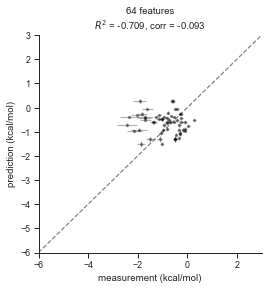

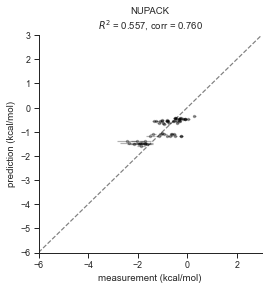

In [17]:
mf.plot_truth_predict(hairpin_model, X_test, y_test, yerr_test, lim=[-6,3])

nupack_offset = np.mean(df.iloc[indices_train,:]['dG_37_NUPACK_salt_corrected'] - y_train)
nupack_prediction = df.iloc[indices_test,:]['dG_37_NUPACK_salt_corrected'] - nupack_offset
mf.plot_truth_predict(hairpin_model, None, y_test, yerr_test, nupack_prediction=nupack_prediction, lim=[-6,3])
# util.save_fig('./fig/motif_fit/hairpin_MANifold_test_set.pdf')

<AxesSubplot:>

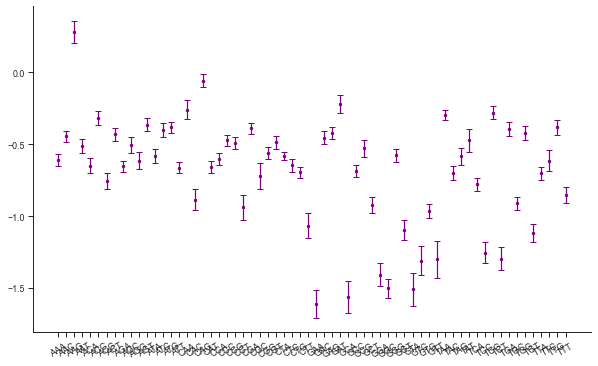

In [18]:
mf.plot_fitted_coef(hairpin_model, c='purple')

Rank of the design matrix A is 64 / 64
Condition number of the design matrix A is 4.40


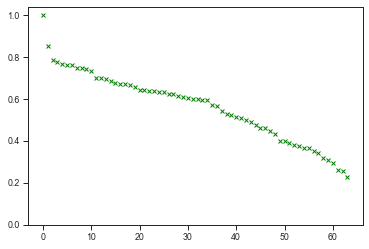

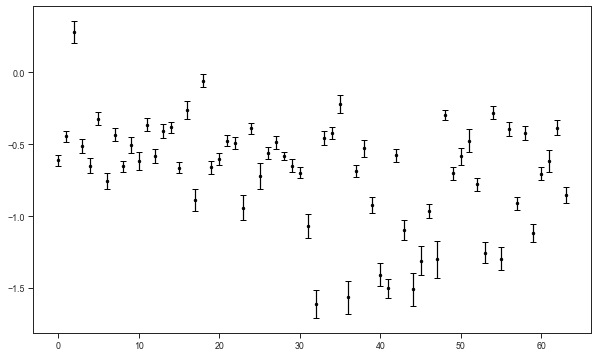

(array([-0.6106963 , -0.44490143,  0.27860883, -0.51269884, -0.64981475,
        -0.32096323, -0.75518889, -0.43234822, -0.65359128, -0.50751905,
        -0.6153339 , -0.36395218, -0.57946907, -0.40448761, -0.38302165,
        -0.66358387, -0.25965277, -0.88704008, -0.05738494, -0.66035997,
        -0.60081482, -0.47433187, -0.49087239, -0.94001757, -0.38821078,
        -0.72081406, -0.55953305, -0.48687388, -0.58292097, -0.64805136,
        -0.69622411, -1.0660046 , -1.60997409, -0.45472402, -0.42237154,
        -0.21952977, -1.5643351 , -0.68453519, -0.52924859, -0.92256464,
        -1.40646554, -1.5017206 , -0.5769657 , -1.0954775 , -1.50936237,
        -1.30926215, -0.96472623, -1.30113427, -0.29454891, -0.70086452,
        -0.58412737, -0.47380914, -0.77879225, -1.2533962 , -0.28051022,
        -1.29660081, -0.39234167, -0.91172562, -0.42208909, -1.11710023,
        -0.70357232, -0.61392395, -0.3837262 , -0.85013662]),
 array([0.03924486, 0.03961729, 0.07761784, 0.04791232, 0.0521

In [178]:
# check properties of the matrix
mf.solve_linear_regression(X_train, y_train, yerr_train, verbose=True)

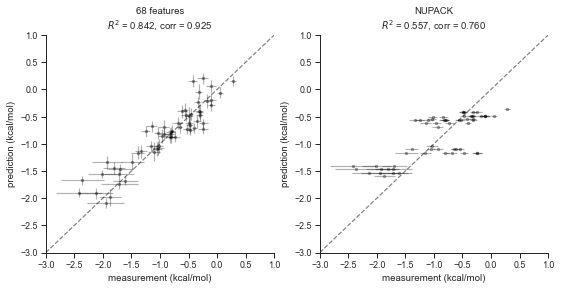

In [106]:
df = arr.query('Series == "TRIloop" & ConstructType == "NN" & scaffold == "GCGC_nan"')
df = df.query("dG_37_se < .5")
count_scaffold_list = np.unique(df.scaffold)[[0]]
feats = mf.get_feature_count_matrix(df, feature_method='get_stack_feature_list_simple_loop', 
                                    loop_base_size=0, fit_intercept=False, symmetry=True)
y = df['dG_37']
y_err = df['dG_37_se']
X_train, X_test, y_train, y_test, yerr_train, yerr_test, indices_train, indices_test = sklearn.model_selection.train_test_split(feats.values, y.values, y_err.values, np.arange(len(y)),
                                                                                                   test_size=0.25, random_state=42, 
                                                                                                   stratify=df.Series)

hairpin_model = mf.LinearRegressionSVD()
hairpin_model.fit(X_train, y_train, yerr_train, feature_names=feats.columns.tolist())

fig, ax = plt.subplots(1,2,figsize=(9,4))
mf.plot_truth_predict(hairpin_model, X_test, y_test, yerr_test, lim=[-3,1], ax=ax[0])

nupack_offset = np.mean(df.iloc[indices_train,:]['dG_37_NUPACK_salt_corrected'] - y_train)
nupack_prediction = df.iloc[indices_test,:]['dG_37_NUPACK_salt_corrected'] - nupack_offset
mf.plot_truth_predict(hairpin_model, None, y_test, yerr_test, nupack_prediction=nupack_prediction, lim=[-3,1], ax=ax[1])
util.save_fig('./fig/motif_fit/hairpin_MANifold_test_set.pdf')

Rank of the design matrix A is 178 / 238
Condition number of the design matrix A is 13.19


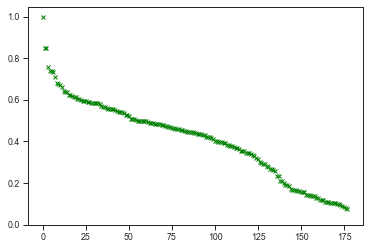

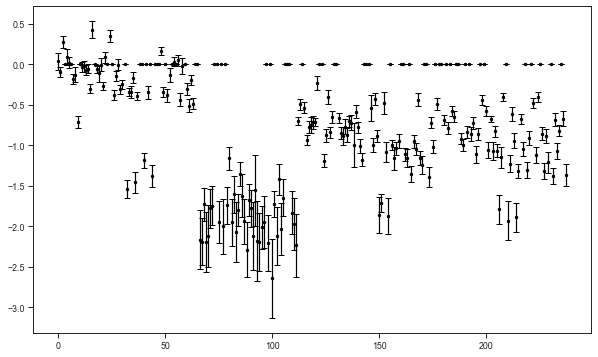

In [55]:
# check properties of the matrix
_ = mf.solve_linear_regression(X_train, y_train, yerr_train, verbose=True)

<AxesSubplot:>

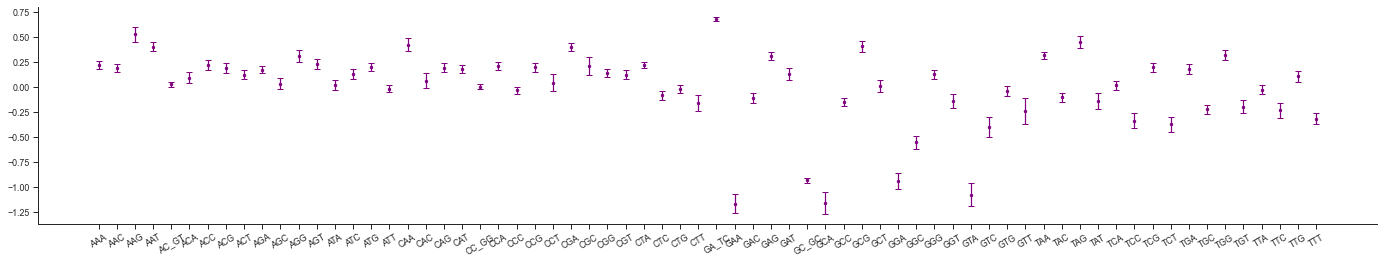

In [186]:
fig, ax = plt.subplots(figsize=(24,4))
mf.plot_fitted_coef(hairpin_model, c='purple', ax=ax)

In [230]:
coef_df = pd.DataFrame(index=hairpin_model.feature_names_in_, data=hairpin_model.coef_, columns=['dG_37'])
for feature in coef_df.index:
    if '_' in feature:
        coef_df.drop(index=feature, inplace=True)
        
coef_df.reset_index(inplace=True)
for i in range(3):
    coef_df['loop_pos%d'%(i+1)] = coef_df['index'].apply(lambda x: x[i])

coef_df['loop_pos_1_3'] = coef_df['index'].apply(lambda x: x[0]+'-'+x[2])
coef_df['loop_pos_2_3'] = coef_df['index'].apply(lambda x: '-'+x[1]+x[2])
coef_df['loop_pos_1_2'] = coef_df['index'].apply(lambda x: x[0]+x[1]+'-')
    
coef_df.sort_values(['loop_pos%d'%(i+1) for i in range(3)], inplace=True)

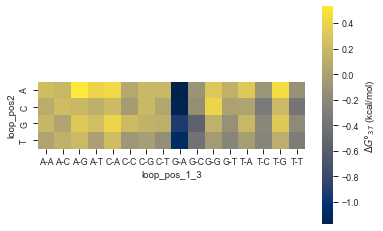

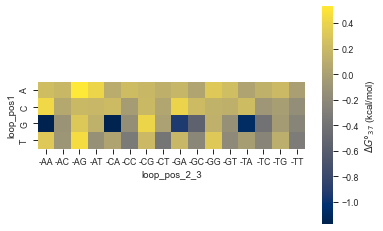

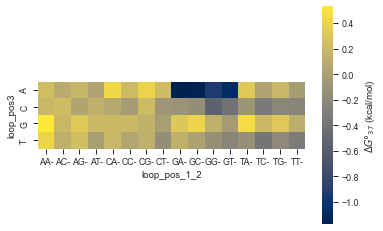

In [233]:
sns.heatmap(pd.pivot(coef_df, columns='loop_pos_1_3', index='loop_pos2', values='dG_37'), cmap='cividis', square=True, 
            cbar_kws={'label': '$\Delta G°_{37}$ (kcal/mol)'})
util.save_fig('./fig/motif_fit/triloop_dG_37_heatmap.pdf')
plt.show()

sns.heatmap(pd.pivot(coef_df, columns='loop_pos_2_3', index='loop_pos1', values='dG_37'), cmap='cividis', square=True, 
            cbar_kws={'label': '$\Delta G°_{37}$ (kcal/mol)'})
plt.show()

sns.heatmap(pd.pivot(coef_df, columns='loop_pos_1_2', index='loop_pos3', values='dG_37'), cmap='cividis', square=True, 
            cbar_kws={'label': '$\Delta G°_{37}$ (kcal/mol)'})
plt.show()

### PLS

In [1]:
import sklearn

In [5]:
from sklearn.cross_decomposition import PLSRegression

In [98]:
df = arr.query('Series == "TRIloop" & ConstructType == "NN" & scaffold == "GCGC_nan"')
df = df.query("dG_37_se < .5")
count_scaffold_list = np.unique(df.scaffold)[[0]]
feats = mf.get_feature_count_matrix(df, feature_method='get_hairpin_loop_feature_list', 
                                    loop_base_size=0, fit_intercept=False, count_scaffold_list=None)
# y = df[['dH', 'Tm']]
# y_err = df[['dH_se', 'Tm_se']]
y = df['dG_37']
y_err = df['dG_37_se']
X_train, X_test, y_train, y_test, yerr_train, yerr_test, indices_train, indices_test = sklearn.model_selection.train_test_split(feats.values, y.values, y_err.values, np.arange(len(y)),
                                                                                                   test_size=0.25, random_state=42, 
                                                                                                   stratify=df.Series)

pls = PLSRegression(n_components=10)

pls.fit(X_train, y_train)

PLSRegression(n_components=10)

In [109]:
df.shape

(238, 45)

Rank of the design matrix A is 64 / 64
Condition number of the design matrix A is 4.40


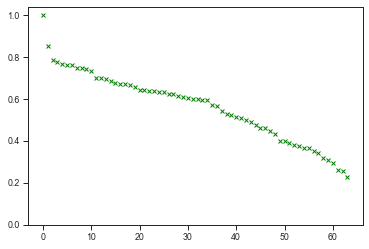

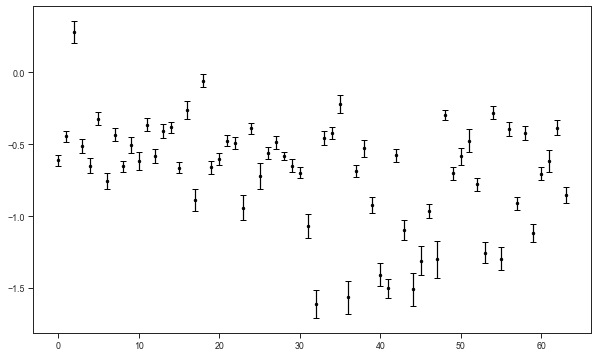

In [97]:
# check properties of the matrix
_ = mf.solve_linear_regression(X_train, y_train, yerr_train, verbose=True)

<AxesSubplot:title={'center':'NUPACK\n$R^2$ = 0.557, corr = 0.760'}, xlabel='measurement (kcal/mol)', ylabel='prediction (kcal/mol)'>

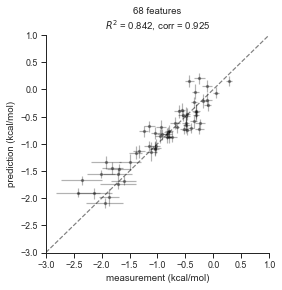

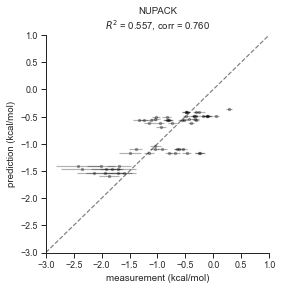

In [102]:
hairpin_model = mf.LinearRegressionSVD()
hairpin_model.fit(X_train, y_train, yerr_train, feature_names=feats.columns.tolist())

mf.plot_truth_predict(hairpin_model, X_test, y_test, yerr_test, lim=[-3,1])

nupack_offset = np.mean(df.iloc[indices_train,:]['dG_37_NUPACK_salt_corrected'] - y_train)
nupack_prediction = df.iloc[indices_test,:]['dG_37_NUPACK_salt_corrected'] - nupack_offset
mf.plot_truth_predict(hairpin_model, None, y_test, yerr_test, nupack_prediction=nupack_prediction, lim=[-3,1])

In [108]:
16**2

256

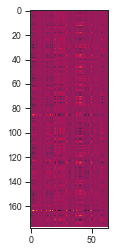

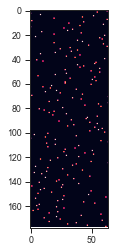

In [76]:
latent_X_train = pls.transform(X_train)
plt.imshow(pls.inverse_transform(latent_X_train))
plt.show()
plt.imshow(X_train)
plt.show()

(-4.011726264681352, 6.637804273797154)

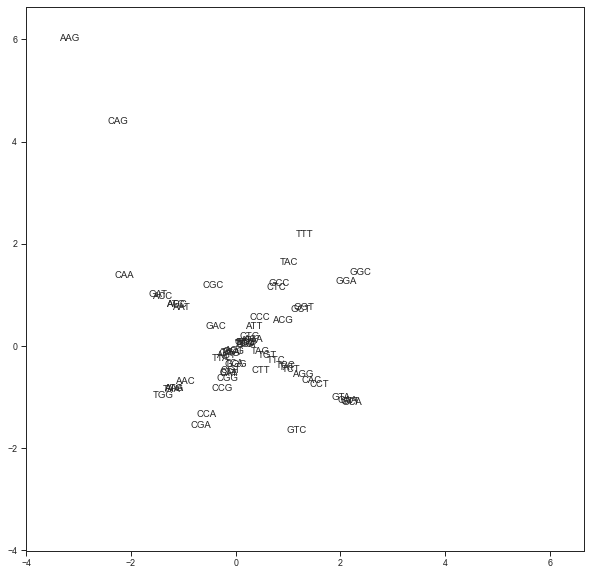

In [93]:
latent_feats = pls.transform(np.eye(X_train.shape[1]))

fig, ax = plt.subplots(figsize=(10,10))
for i in range(latent_feats.shape[0]):
    plt.text(latent_feats[i,0], latent_feats[i,1], feats.columns[i])
    
plt.xlim([latent_feats.min(), latent_feats.max()])
plt.ylim([latent_feats.min(), latent_feats.max()])

### Heatmaps of loops

#### Tetraloops

In [79]:
query = 'Series == "TETRAloop" & ConstructType == "NN" & scaffold == "GCGC_nan"'
df = arr.query(query)
df_anno = annotation.query(query)
# df = arr.query('Series == "TETRAloop" & ConstructType == "NN"')
print(df.shape)

(985, 43)


In [80]:
def get_loop(seq, loop_size=4):
    stem_size = int((len(seq) - loop_size) / 2)
    return seq[stem_size: stem_size+loop_size]

def get_closing_stack(seq, loop_size=4, closing_stack_size=1):
    stem_size = int((len(seq) - loop_size) / 2)
    return seq[stem_size - closing_stack_size : stem_size] + seq[-stem_size : -stem_size + closing_stack_size]


df['loop'] = df.RefSeq.apply(lambda seq: get_loop(seq, loop_size=4))
df['closing_stack'] = df.RefSeq.apply(lambda seq: get_closing_stack(seq, loop_size=4, closing_stack_size=1))
df.sort_values(by='loop', inplace=True)
df['loop_out'] = df.apply(lambda x: x.loop[0]+x.loop[-1]+'/'+x.closing_stack, axis=1)
df['loop_center'] = df['loop'].apply(lambda x: x[1:3])

df_anno['loop'] = df_anno.RefSeq.apply(lambda seq: get_loop(seq, loop_size=4))
df_anno['closing_stack'] = df_anno.RefSeq.apply(lambda seq: get_closing_stack(seq, loop_size=4, closing_stack_size=1))
df_anno.sort_values(by='loop', inplace=True)
df_anno['loop_out'] = df_anno['loop'].apply(lambda x: x[0]+x[-1])
df_anno['loop_center'] = df_anno['loop'].apply(lambda x: x[0]+x[-1])

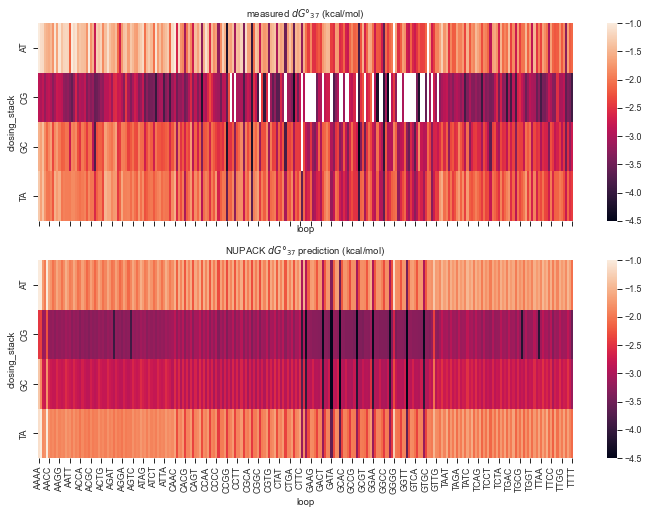

In [81]:
offset = np.nanmean((df.pivot_table(index='closing_stack', columns='loop', values='dG_37') - df.pivot_table(index='closing_stack', columns='loop', values='dG_37_NUPACK_salt_corrected')).values)

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
args = dict(vmin=-4.5, vmax=-1)
# args=dict()
sns.heatmap(df.pivot_table(index='closing_stack', columns='loop', values='dG_37') - offset, ax=ax[0], **args)
ax[0].set_title('measured $dG°_{37}$ (kcal/mol)')
sns.heatmap(df_anno.pivot_table(index='closing_stack', columns='loop', values='dG_37_NUPACK_salt_corrected'), ax=ax[1], **args)
ax[1].set_title('NUPACK $dG°_{37}$ prediction (kcal/mol)')

util.save_fig('./fig/heatmaps/tetraloop_scaffoldA_dG_37.pdf')

offset is -10.3963


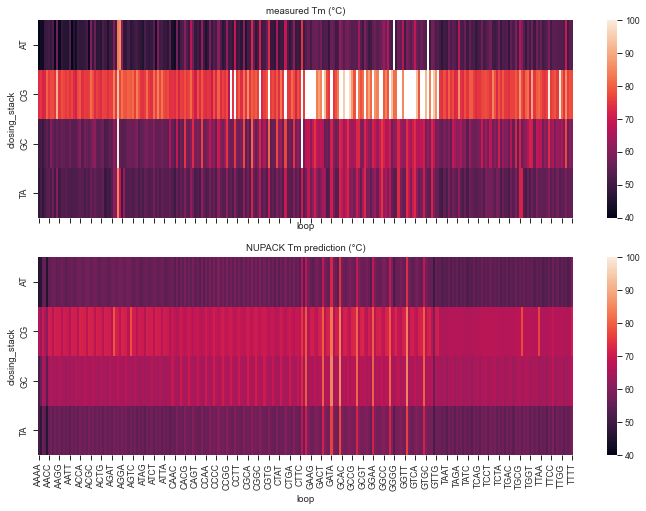

In [21]:
measured_pivot = df.pivot_table(index='closing_stack', columns='loop', values='Tm')
nupack_pivot = df_anno.pivot_table(index='closing_stack', columns='loop', values='Tm_NUPACK_salt_corrected')
offset = np.nanmean(measured_pivot.values - nupack_pivot.values)
print('offset is %.4f'% offset)

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
args = dict(vmin=40, vmax=100)
sns.heatmap(measured_pivot - offset, ax=ax[0], **args)
ax[0].set_title('measured Tm (°C)')
sns.heatmap(nupack_pivot, ax=ax[1], **args)
ax[1].set_title('NUPACK Tm prediction (°C)')

util.save_fig('./fig/heatmaps/tetraloop_scaffoldA_Tm.pdf')

#### Triloops

In [82]:
# query = 'Series == "TRIloop" & ConstructType == "NN" & scaffold == "GCGC_nan"'
query = 'Series == "TRIloop" & scaffold == "GCGC_nan"'
df = arr.query(query)
df_anno = annotation.query(query)

In [83]:
def get_loop(seq, loop_size=4):
    stem_size = int((len(seq) - loop_size) / 2)
    return seq[stem_size: stem_size+loop_size]

def get_closing_stack(seq, loop_size=4, closing_stack_size=1):
    stem_size = int((len(seq) - loop_size) / 2)
    return seq[stem_size - closing_stack_size : stem_size] + seq[-stem_size : -stem_size + closing_stack_size]

def add_feats_loop_df(loop_df, loop_size=4):
    df = loop_df.copy()
    df['loop'] = df.RefSeq.apply(lambda seq: get_loop(seq, loop_size=loop_size))
    df['closing_stack'] = df.RefSeq.apply(lambda seq: get_closing_stack(seq, loop_size=loop_size, closing_stack_size=1))
    df.sort_values(by='loop', inplace=True)
    df['loop_out'] = df.apply(lambda x: x.loop[0]+x.loop[-1]+'/'+x.closing_stack, axis=1)
    df['loop_center'] = df['loop'].apply(lambda x: x[1:3])
    return df

df = add_feats_loop_df(df, loop_size=3)
df_anno = add_feats_loop_df(df, loop_size=3)

offset adjustment is 0.8914


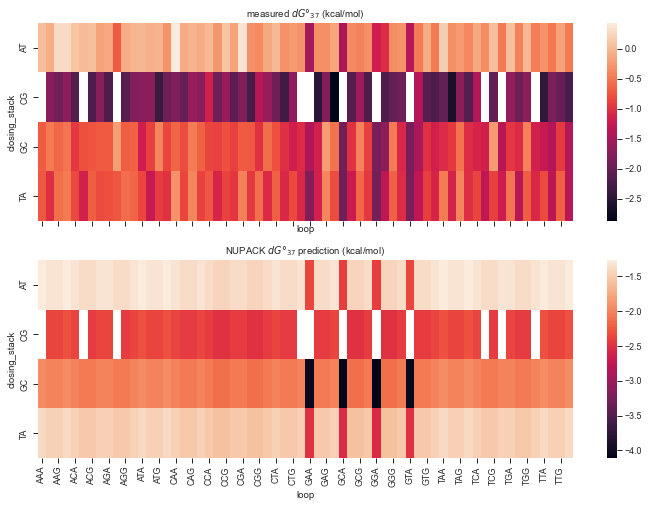

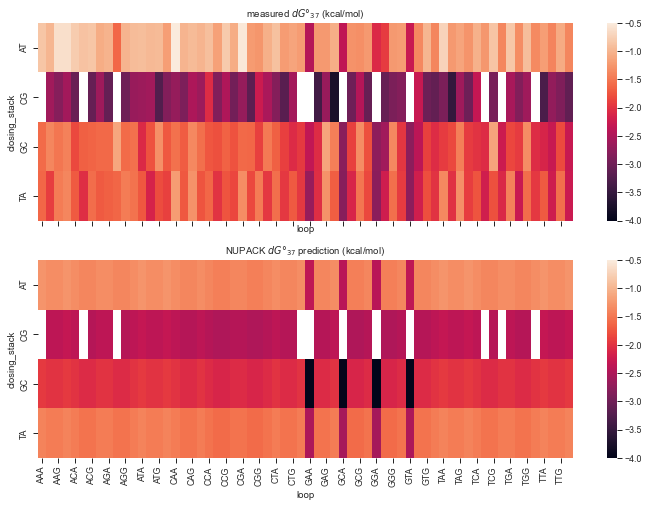

In [88]:
def plot_adjusted_heatmap_comparison(df1, df2, parameter='dG_37', parameter2=None, index='closing_stack', columns='loop',
                                     args=dict(), adjust_offset=True, figname='heatmap.pdf'):
    if parameter2 is None:
        parameter2 = parameter + '_NUPACK_salt_corrected'
        
    pivot1 = df1.pivot_table(index=index, columns=columns, values=parameter)
    pivot2 = df2.pivot_table(index=index, columns=columns, values=parameter2)
    
    if adjust_offset:
        offset = np.nanmean(pivot1 - pivot2)
        print('offset adjustment is %.4f'% offset)
    else:
        offset = 0

    fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)    

    sns.heatmap(pivot1 - offset, ax=ax[0], **args)
    sns.heatmap(pivot2, ax=ax[1], **args)
        
    if parameter == 'dG_37':
        ax[0].set_title('measured $dG°_{37}$ (kcal/mol)')
        ax[1].set_title('NUPACK $dG°_{37}$ prediction (kcal/mol)')
    elif parameter == 'Tm':
        ax[0].set_title('measured $Tm$ (°C)')
        ax[1].set_title('NUPACK $Tm$ prediction (°C)')
    else:
        ax[0].set_title(f'measured ${parameter}$ (kcal/mol)')
        ax[1].set_title(f'NUPACK ${parameter}$ prediction (kcal/mol)')
        
    util.save_fig('./fig/heatmaps/' + figname)
    
args = dict(vmin=-4, vmax=-0.5)
plot_adjusted_heatmap_comparison(df, df_anno, parameter='dG_37', figname='triloop_dG_37_heatmap_raw.pdf', adjust_offset=False)
plot_adjusted_heatmap_comparison(df, df_anno, parameter='dG_37', figname='triloop_dG_37_heatmap_adjusted.pdf', adjust_offset=True, args=args)

offset adjustment is 1.3127
offset adjustment is -10.3963


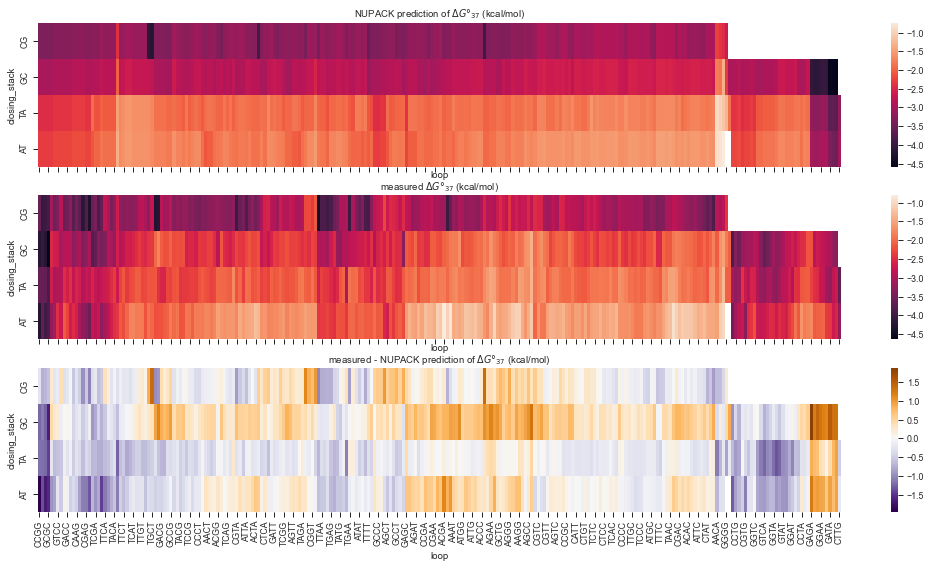

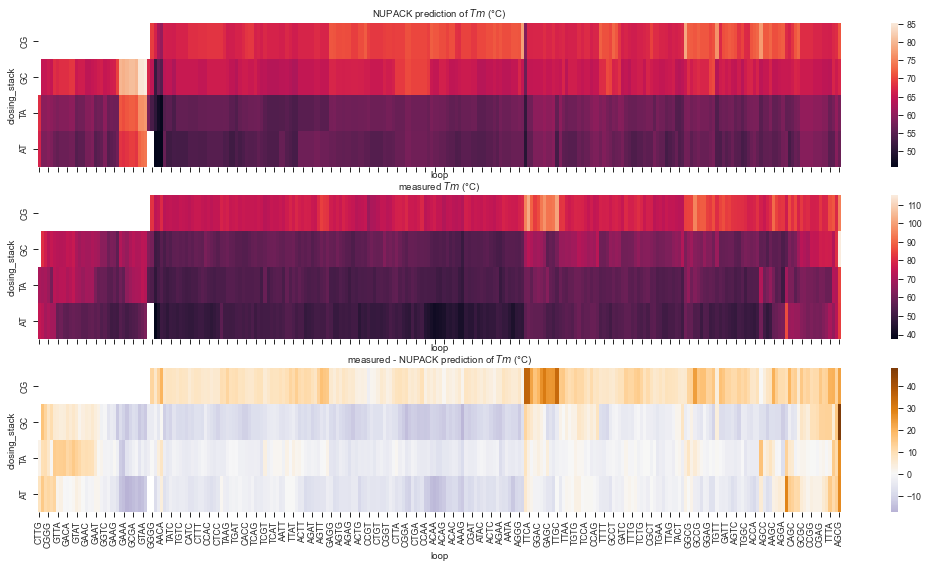

In [171]:
# Thu 06/09/2022
from scipy.cluster.hierarchy import ward, linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist

def plot_adjusted_heatmap_comparison(df1, df2, parameter='dG_37', parameter2=None, index='closing_stack', columns='loop',
                                 args=dict(), dd=False, adjust_offset=True, figname='heatmap.pdf'):
    if parameter2 is None:
        parameter2 = parameter + '_NUPACK_salt_corrected'
        
    pivot1 = df1.pivot_table(index=index, columns=columns, values=parameter)
    pivot2 = df2.pivot_table(index=index, columns=columns, values=parameter2)
    
    if adjust_offset:
        offset = np.nanmean(pivot1 - pivot2)
        print('offset adjustment is %.4f'% offset)
    else:
        offset = 0
        
    if dd:
        stack_ref = 'CG'
        loop_ref = 'GAT'
        pivot1 -= pivot1.loc[stack_ref, loop_ref]
        pivot2 -= pivot2.loc[stack_ref, loop_ref]

    nan = -999
    figsize = (12, 4)
    
    # g = sns.clustermap(np.nan_to_num(pivot2, nan=nan), 
    #                row_cluster=True, figsize=figsize, **args)
    # row_ind, col_ind = g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind
    # plt.show()
    
    pivot1_filled = np.nan_to_num(pivot1, nan=nan)
    pivot2_filled = np.nan_to_num(pivot2, nan=nan)
    A = (np.concatenate((pivot1_filled, pivot2_filled), axis=0)).T
    col_ind = leaves_list(linkage(pdist(A, 'cityblock'), method='ward', optimal_ordering=True))
    B = np.concatenate((pivot1_filled, pivot2_filled), axis=1)
    row_ind = leaves_list(linkage(pdist(B, 'cityblock'), method='ward', optimal_ordering=True))
    
    fig, ax = plt.subplots(3, 1, figsize=(18, 9), sharex=True)
    sns.heatmap((pivot1 - offset).iloc[row_ind, :].iloc[:, col_ind],
                ax=ax[1], **args)
    sns.heatmap(pivot2.iloc[row_ind, :].iloc[:, col_ind], 
                ax=ax[0], **args)
    sns.heatmap((pivot1 - pivot2 - offset).iloc[row_ind, :].iloc[:, col_ind], 
                ax=ax[2], center=0, cmap='PuOr_r')
    
    if parameter == 'dG_37':
        title_text = '$\Delta G°_{37}$ (kcal/mol)'
    elif parameter == 'Tm':
        title_text = '$Tm$ (°C)'
    else:
        title_text = '${parameter}$ (kcal/mol)'
    
    if dd:
        title_text = '$\Delta$' + title_text
        
    ax[0].set_title(f'NUPACK prediction of {title_text}')
    ax[1].set_title(f'measured {title_text}')
    ax[2].set_title(f'measured - NUPACK prediction of {title_text}')
    
    util.save_fig('./fig/heatmaps/' + figname)
    
args = dict(vmin=-5, vmax=1)
plot_adjusted_heatmap_comparison(df, df_anno, parameter='dG_37', figname='triloop_dG_37_heatmap_adjusted.pdf', adjust_offset=True)
plot_adjusted_heatmap_comparison(df, df_anno, parameter='Tm', figname='triloop_dG_37_heatmap_adjusted.pdf', adjust_offset=True)

offset adjustment is 1.3127
offset adjustment is -10.3963


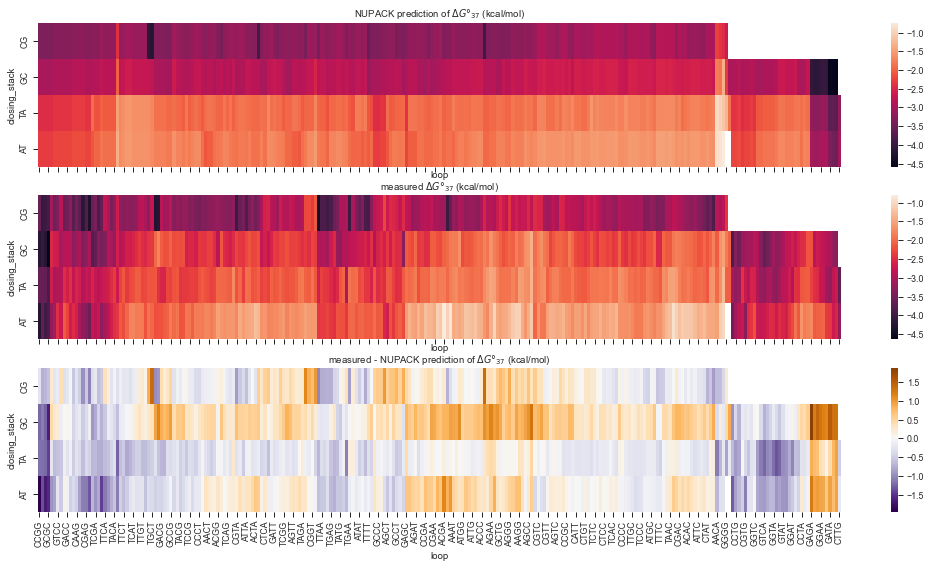

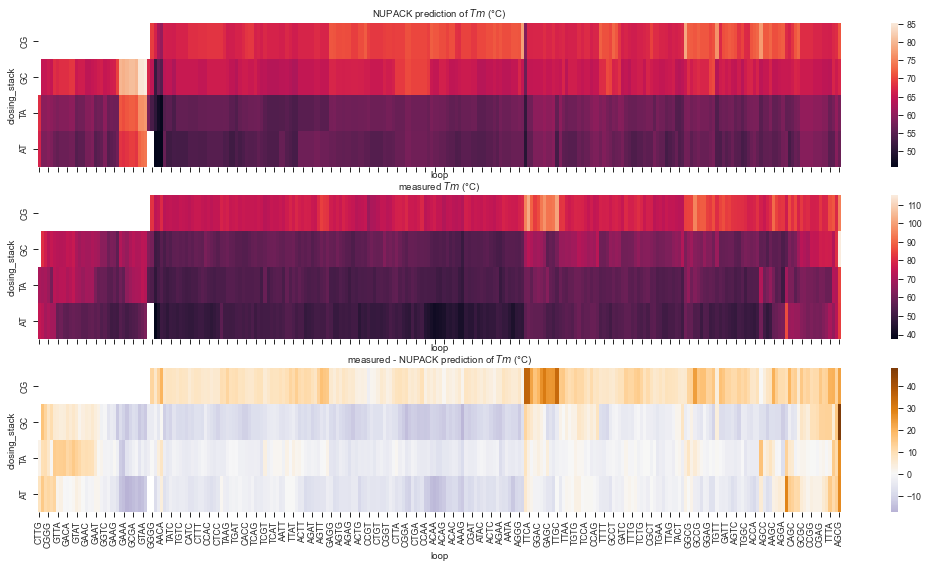

In [172]:
query = 'Series == "TETRAloop" & ConstructType == "NN" & scaffold == "GCGC_nan"'
df = arr.query(query)
df_anno = annotation.query(query)
df = add_feats_loop_df(df, loop_size=4)
df_anno = add_feats_loop_df(df, loop_size=4)

plot_adjusted_heatmap_comparison(df, df_anno, parameter='dG_37', figname='tetraloop_dG_37_heatmap_adjusted.pdf', adjust_offset=True)
plot_adjusted_heatmap_comparison(df, df_anno, parameter='Tm', figname='tetraloop_dG_37_heatmap_adjusted.pdf', adjust_offset=True)

offset adjustment is -7.9715


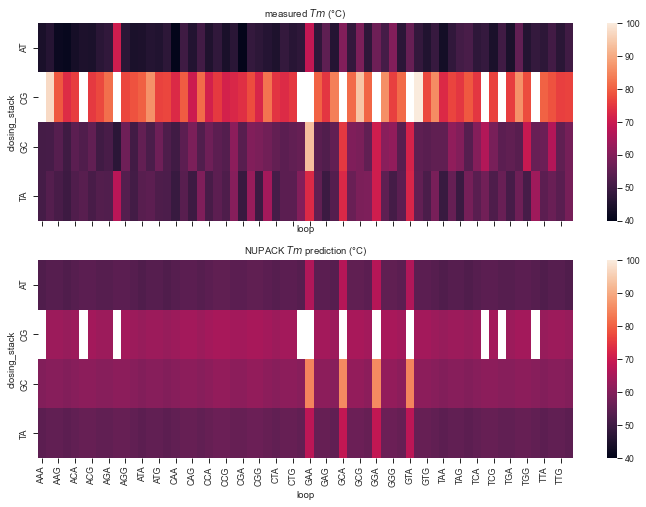

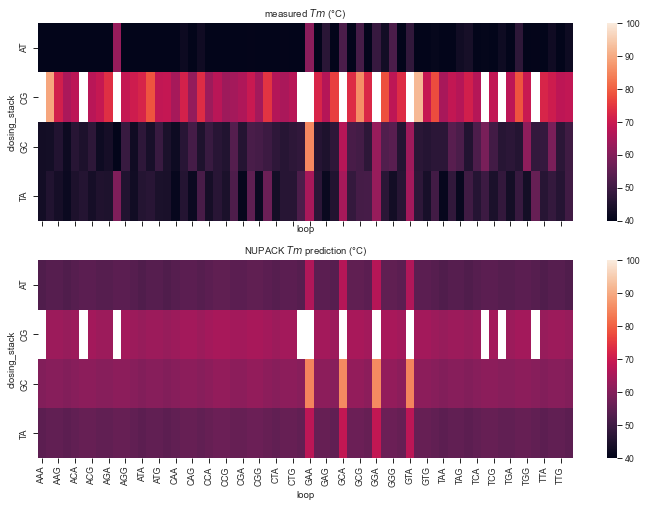

In [64]:
args = dict(vmin=40, vmax=100)
plot_adjusted_heatmap_comparison(df, df_anno, parameter='Tm', 
                                 figname='triloop_Tm_heatmap_adjusted.pdf', 
                                 adjust_offset=True, args=args)
plot_adjusted_heatmap_comparison(df, df_anno, parameter='Tm', 
                                 figname='triloop_Tm_heatmap_raw.pdf', 
                                 adjust_offset=False, args=args)

## Heatmaps of mismatches and bulges

In [65]:
query = 'Series == "MisMatches"'
df = arr.query(query)
df_anno = annotation.query(query)

In [69]:
np.unique(df.query('ConstructType == "Centered"').scaffold)

array(['CGCG_CGAAA', 'CGCG_CGAAC', 'CGCG_CGAAG', 'CGCG_CGAAT',
       'CGCG_CGACA', 'CGCG_CGACC', 'CGCG_CGACG', 'CGCG_CGACT',
       'CGCG_CGAGA', 'CGCG_CGAGC', 'CGCG_CGAGG', 'CGCG_CGAGT',
       'CGCG_CGATA', 'CGCG_CGATC', 'CGCG_CGATG', 'CGCG_CGATT',
       'CGCG_CGCAA', 'CGCG_CGCAC', 'CGCG_CGCAG', 'CGCG_CGCAT',
       'CGCG_CGCCA', 'CGCG_CGCCC', 'CGCG_CGCCG', 'CGCG_CGCCT',
       'CGCG_CGCGA', 'CGCG_CGCGC', 'CGCG_CGCGG', 'CGCG_CGCGT',
       'CGCG_CGCTA', 'CGCG_CGCTC', 'CGCG_CGCTG', 'CGCG_CGCTT',
       'CGCG_CGGAA', 'CGCG_CGGAC', 'CGCG_CGGAG', 'CGCG_CGGAT',
       'CGCG_CGGCA', 'CGCG_CGGCC', 'CGCG_CGGCG', 'CGCG_CGGCT',
       'CGCG_CGGGA', 'CGCG_CGGGC', 'CGCG_CGGGG', 'CGCG_CGGGT',
       'CGCG_CGGTA', 'CGCG_CGGTC', 'CGCG_CGGTG', 'CGCG_CGGTT',
       'CGCG_CGTAA', 'CGCG_CGTAC', 'CGCG_CGTAG', 'CGCG_CGTAT',
       'CGCG_CGTCA', 'CGCG_CGTCC', 'CGCG_CGTCG', 'CGCG_CGTCT',
       'CGCG_CGTGA', 'CGCG_CGTGC', 'CGCG_CGTGG', 'CGCG_CGTGT',
       'CGCG_CGTTA', 'CGCG_CGTTC', 'CGCG_CGTTG', 'CGCG_

In [72]:
df.query('ConstructType == "Centered"')[['RefSeq', 'scaffold']]

,RefSeq,scaffold
SEQID,,
MMCNN0,CGAAACGGAAACGTATCG,CGCG_CGTAT
MMCNN1,CGAAACGGAAACGTCTCG,CGCG_CGTCT
MMCNN10,CGAGACGGAAACGTTTCG,CGCG_CGTTT
MMCNN100,CGGCACGGAAACGTCCCG,CGCG_CGTCC
MMCNN101,CGGCACGGAAACGTTCCG,CGCG_CGTTC
...,...,...
MMCNNN995,GTTGAGCGAAAGCTGAAC,GC_CG
MMCNNN996,GTTAACCGAAAGGTAAAC,GC_CG
MMCNNN997,GTTAACCGAAAGGTCAAC,GC_CG


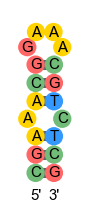

CGTCT


In [78]:
seqid = 'MMCNN1'
draw_struct(df.loc[seqid, 'RefSeq'], df.loc[seqid, 'TargetStruct'])
print(df.loc[seqid, 'topScaffold'])